# Modeling
In this notebook we perform our Bayesian Logistic Regression using MCMC.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
import scipy as sc
import pickle
import pymc3 as pm
import arviz as az
from sklearn.metrics import f1_score, accuracy_score, auc, classification_report
import os
sns.set_theme(context="notebook", font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

## Data 
Since some of our variables are binary, we perform min-max scaling such that all features are in the range $[0,1]$.

In [2]:
scaler = StandardScaler()

In [3]:
with open('feat_cols.pkl', 'rb') as f:
    feat_cols = pickle.load(f)

In [4]:
data = pd.read_csv("ld_clean.csv")
status = data['Status']
data = data[feat_cols + ['Status']]
data = data.infer_objects()
data.fillna(data.mean(), inplace=True)
data[feat_cols] = scaler.fit_transform(data[feat_cols])
data.head()

,co-applicant_credit_type_EXP,Gender_Joint,total_units_3U,Upfront_charges,Neg_ammortization_neg_amm,construction_type_mh,Secured_by_land,Security_Type_Indriect,occupancy_type_sr,Region_North,...,age_<25,approv_in_adv_nopre,age_35-44,lump_sum_payment_lpsm,credit_type_CIB,income,loan_limit_ncf,loan_purpose_p1,LTV,Status
0,-0.999233,-0.621238,-0.051483,-0.810002,2.969554,-0.0149,-0.0149,-0.0149,-0.146627,-1.005220,...,-0.095298,-2.320734,1.877235,-0.152595,-0.692133,0.391336,-0.27121,1.817171,0.190766,0
1,-0.999233,-0.621238,-0.051483,-0.810002,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,0.430898,-0.532698,-0.152595,-0.692133,0.763653,-0.27121,-0.550306,-0.086685,0
2,1.000767,1.609690,-0.051483,-0.993270,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,-2.320734,-0.532698,-0.152595,-0.692133,0.540263,-0.27121,1.817171,0.500127,0
3,1.000767,1.609690,-0.051483,-0.879305,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,-2.320734,1.877235,-0.152595,-0.692133,0.484415,-0.27121,1.817171,-0.068113,0
4,1.000767,1.609690,-0.051483,0.583759,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,-2.320734,-0.532698,-0.152595,-0.692133,-0.297449,-0.27121,-0.550306,0.167040,0


### Split the data
We now split the data using a 70/30 train/test split.

In [5]:
train_df = data.sample(frac=0.7,random_state=5822)
val_df = data.drop(train_df.index)

In [6]:
train_df.head()

,co-applicant_credit_type_EXP,Gender_Joint,total_units_3U,Upfront_charges,Neg_ammortization_neg_amm,construction_type_mh,Secured_by_land,Security_Type_Indriect,occupancy_type_sr,Region_North,...,age_<25,approv_in_adv_nopre,age_35-44,lump_sum_payment_lpsm,credit_type_CIB,income,loan_limit_ncf,loan_purpose_p1,LTV,Status
78554,1.000767,1.609690,-0.051483,-0.993270,2.969554,-0.0149,-0.0149,-0.0149,6.820040,-1.005220,...,-0.095298,0.430898,-0.532698,-0.152595,-0.692133,-0.185754,-0.27121,-0.550306,-0.555939,1
49350,1.000767,1.609690,-0.051483,-0.261738,2.969554,-0.0149,-0.0149,-0.0149,-0.146627,-1.005220,...,-0.095298,0.430898,1.877235,-0.152595,1.444809,-0.353297,-0.27121,-0.550306,0.416250,0
48569,1.000767,-0.621238,-0.051483,-0.993270,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,0.430898,-0.532698,-0.152595,-0.692133,-0.260218,-0.27121,1.817171,0.650206,1
29625,1.000767,1.609690,-0.051483,-0.993270,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,0.430898,1.877235,-0.152595,-0.692133,-0.176446,-0.27121,-0.550306,0.655915,0
23503,1.000767,1.609690,-0.051483,0.000166,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,...,-0.095298,0.430898,-0.532698,-0.152595,-0.692133,-0.353297,-0.27121,-0.550306,-0.953902,0


# Defining our model
We now define the model for our Bayesian logistic regression as $p(y_i=1|\theta) = \sigma(\beta_0 + \sum\limits_{i=1}^{30} \beta_ix_i)$, where $\theta=\{\beta_i\}_{i=0}^{30}$ and $\sigma$ is the logstic sigmoid. To start, we assume all of our parameters follow a normal distribution $\mathcal{N}(0,1)$. We run our model for 10,000 steps on 4 chains with a burn-in period of 500 steps.

In [8]:
with pm.Model() as blr:
    if os.path.isfile('trace.pkl'):
        with open('trace.pkl', 'rb') as f:
            trace = pickle.load(f)
    else:
        assert 1 == 0
        betas = []
        for i in range(31):
            betas.append(pm.Normal(f'b{i}', 0,1))
        logit = betas[0]
        for beta, feat in zip(betas[1:], feat_cols):
            logit += beta * train_df[feat]
        likelihood = pm.invlogit(logit)
        pm.Bernoulli(name='pred', p=likelihood, observed=train_df['Status'])
        step = pm.Metropolis()
        trace = pm.sample(10_000,tune=500, step=step, chains=4)
    

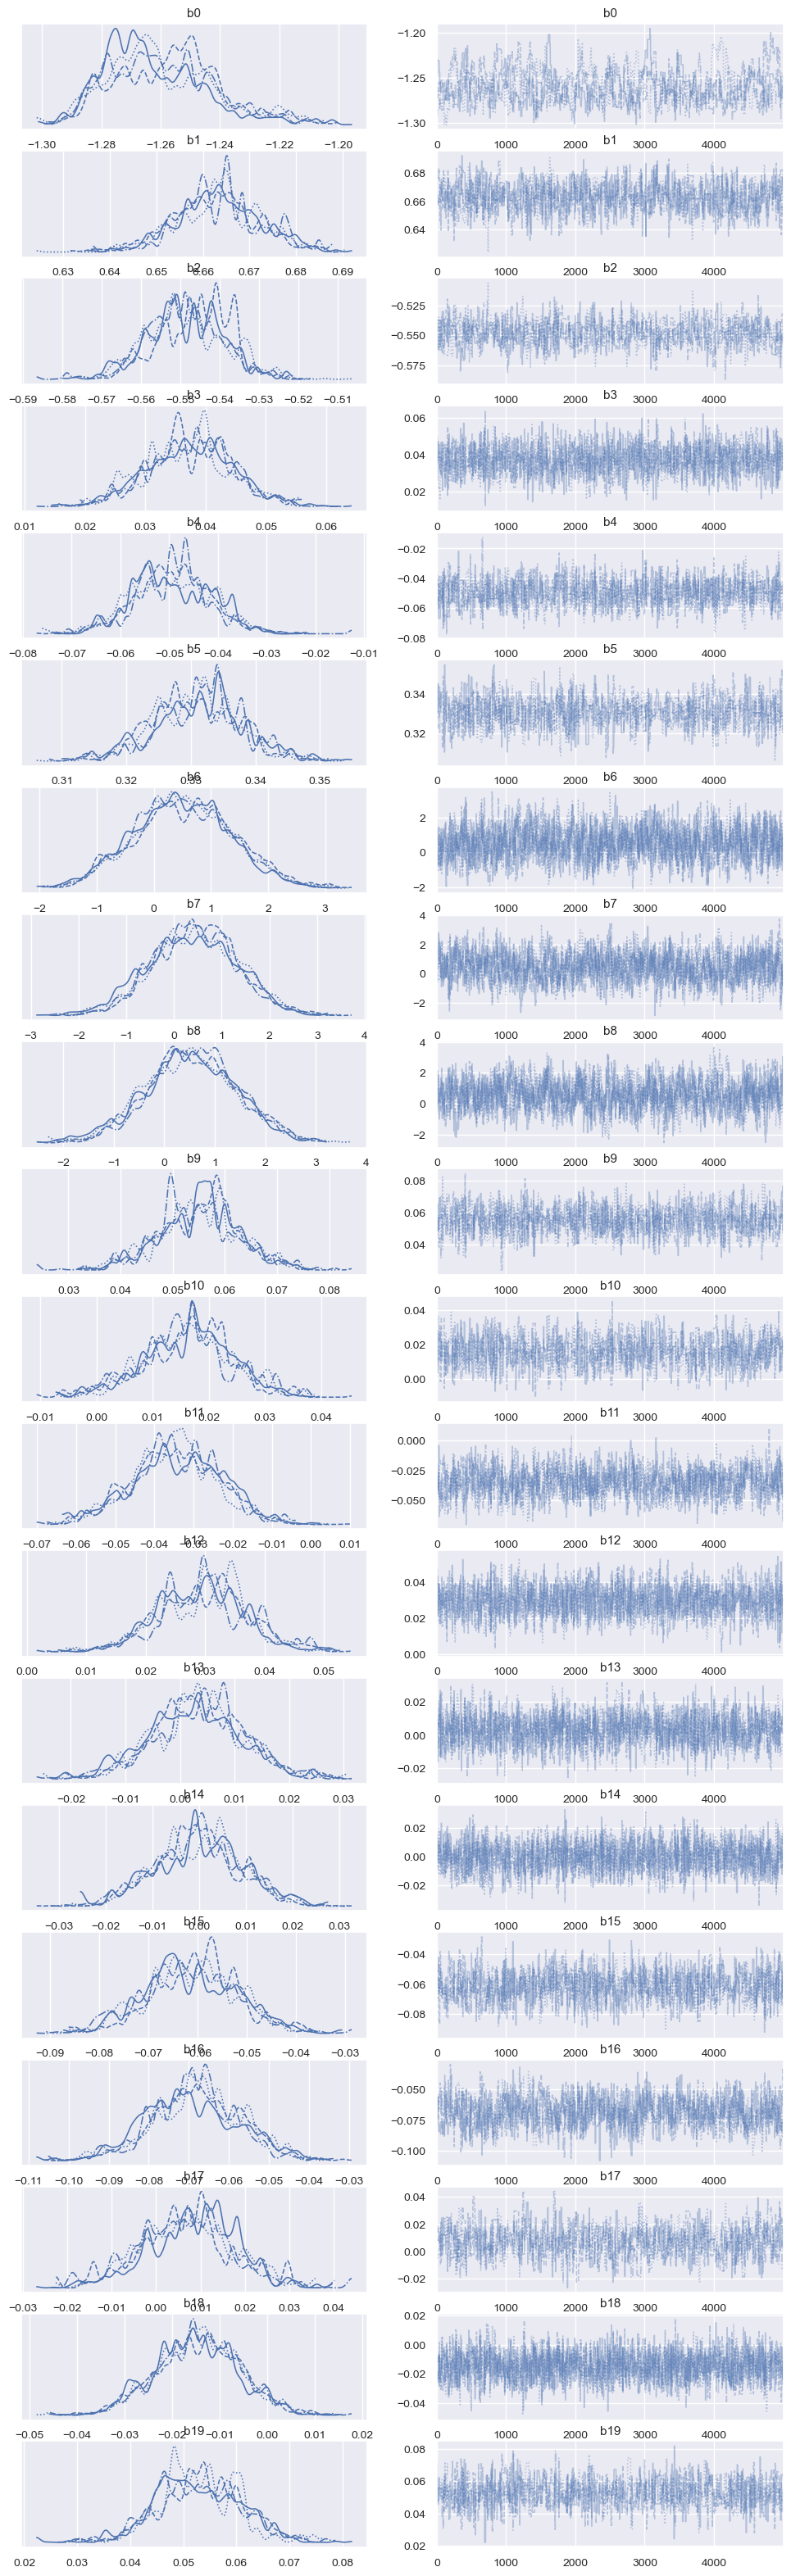

In [9]:
with blr:
    pm.traceplot(trace)

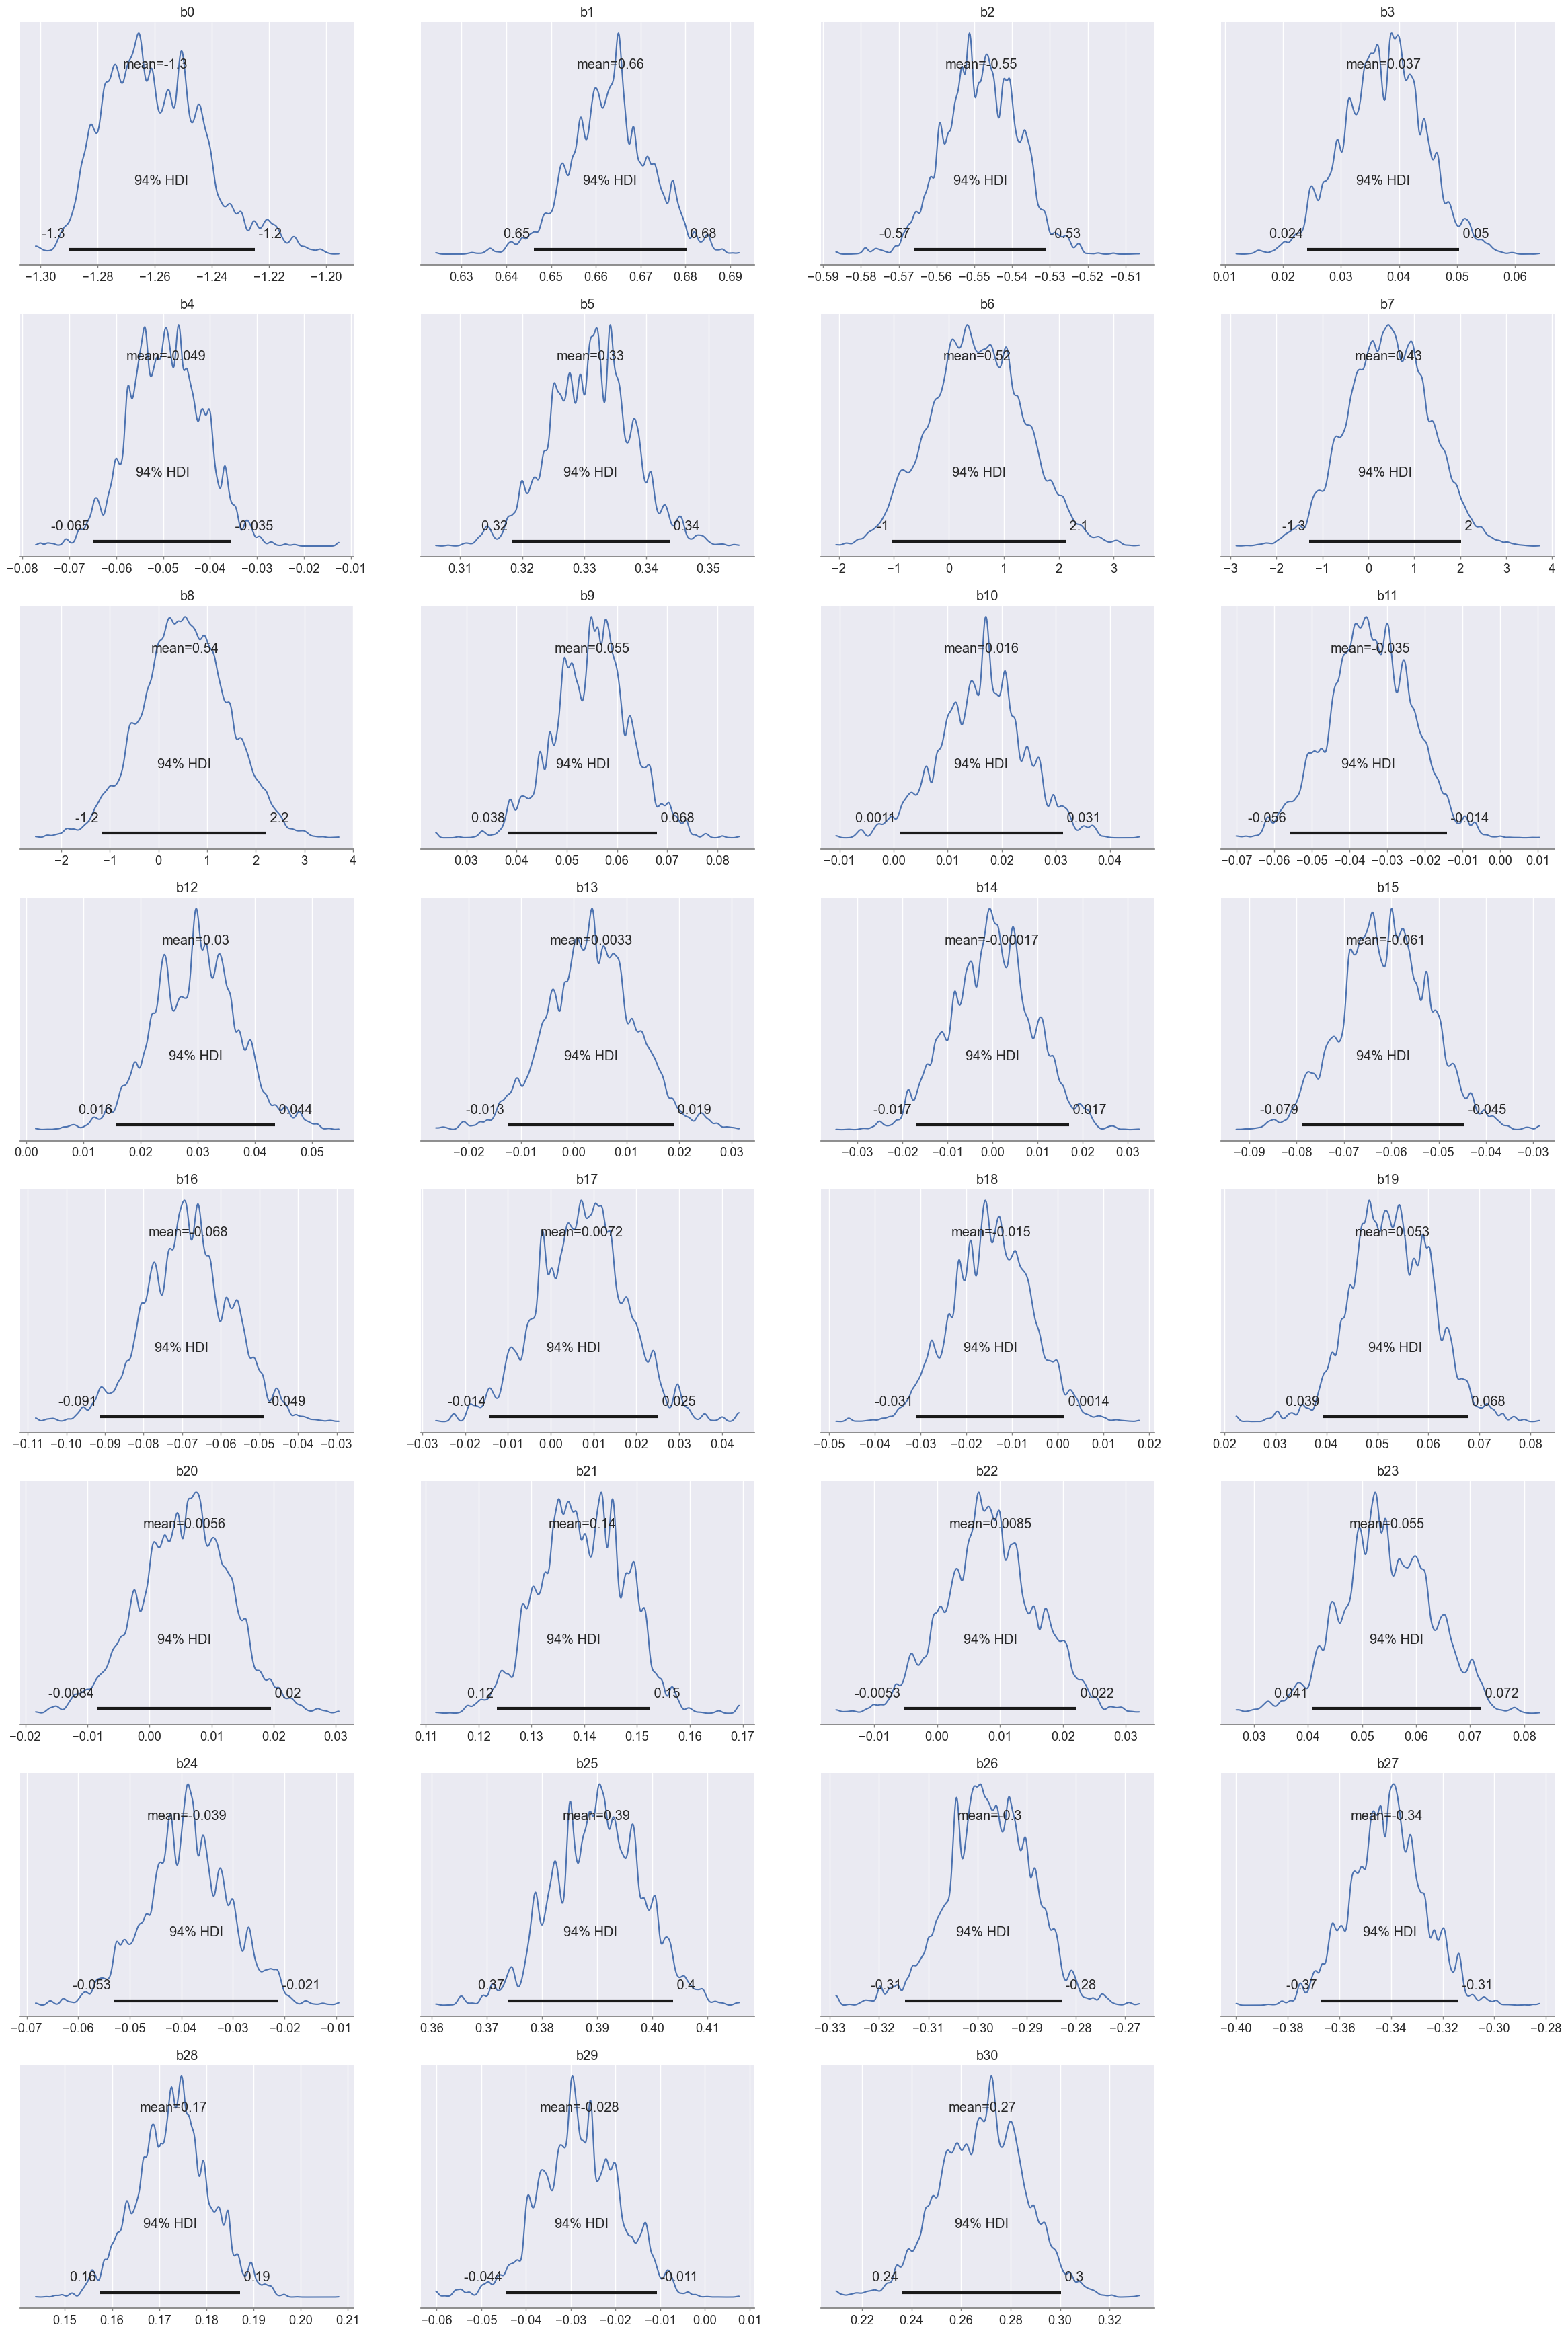

In [10]:
with blr:
    pm.plot_posterior(trace)

In [11]:
logistic = lambda x: 1/(1+np.exp(-x))

In [12]:
logit = trace.get_values('b0').mean()
for i, feat in zip(range(1,31), feat_cols):
    logit += trace.get_values(f'b{i}').mean() * np.array(val_df[feat].to_list())

In [13]:
from sklearn.metrics import f1_score, accuracy_score, auc, classification_report

In [14]:
print(classification_report(val_df['Status'].to_list(), np.uint8(logistic(logit) > 0.5)))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     33532
           1       0.70      0.22      0.34     11068

    accuracy                           0.78     44600
   macro avg       0.75      0.60      0.61     44600
weighted avg       0.77      0.78      0.74     44600



In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_df[feat_cols], train_df['Status'])

In [16]:
print(classification_report(val_df['Status'], clf.predict(val_df[feat_cols])))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     33532
           1       0.70      0.22      0.34     11068

    accuracy                           0.78     44600
   macro avg       0.75      0.60      0.61     44600
weighted avg       0.77      0.78      0.74     44600

